In [1]:
from tools_stance import * 
from models import *
import torch 
import gc
import pandas as pd

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="support"
dict_cl[1]="denying"
dict_cl[2]="questioning"
dict_cl[3]="commenting"

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

path="../Datasets/CSV_Stance/"
train =pd.read_csv(path + "train_semeval_raw.csv")
val=pd.read_csv(path + "dev_semeval_raw.csv")
test=pd.read_csv(path + "test_semeval_raw.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


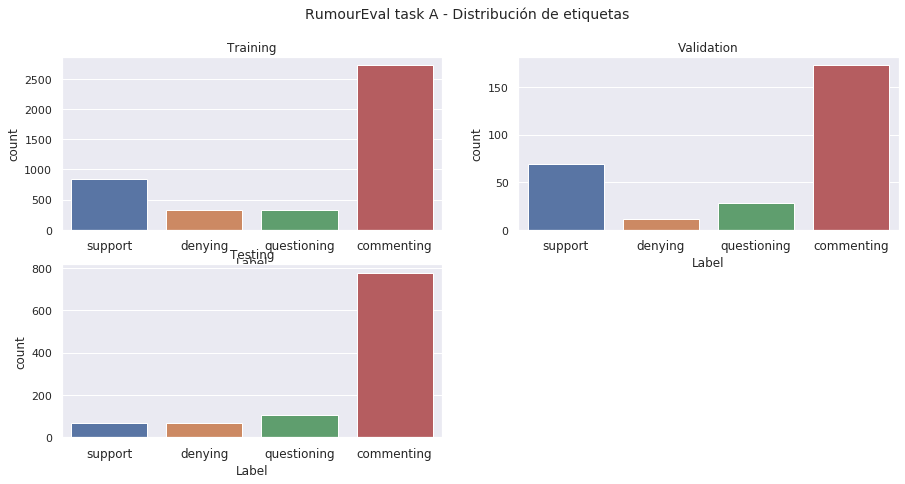

In [2]:
import seaborn as sns
sns.set(font_scale=1)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,7))
j=220
labs=['support', 'denying', 'questioning', 'commenting']
data=[train['Label'], val['Label'], test["Label"]]
name=["Training", "Validation", "Testing"]
for i in range(3):
    j+=1
    h=fig.add_subplot(j)
    ax= sns.countplot(data[i], order=labs)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    h.title.set_text(str(name[i]))

fig.suptitle("RumourEval task A - Distribución de etiquetas", fontsize=14)
plt.show()

In [3]:
def cm_norma(matrix):
    return matrix/matrix.sum(axis=-1, keepdims=True)
    
    
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq, trainPredict))
    """print ("")
    print ("------ Training ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=cm_norma(confusion_matrix(etiq_v, trainPredict))
    """print ("")
    print ("------ Validation ------")
    print ("Accuracy", name_model, ": %.3f" % acc)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1)"""
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=cm_norma(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("------ Testing ------")
    print ("Accuracy", name_model, ": %.3f" % acc_t)     
    print ("F1-score macro", name_model, ": %.3f" % f1_ma_t)
    np.set_printoptions(precision=3)
    print ("F1-score None", name_model, ":", f1_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [4]:
import os 
embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        #print ("Problema con line ", line)
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193513 terminos con sus vectores de embedding.


In [5]:
MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(1193513, 200)

In [19]:
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= [1.0, 1.0, 1.0, 1.0]
#class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)

ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

Pesos de clases: [1.0, 1.0, 1.0, 1.0]


In [20]:
sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

In [21]:
input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

In [22]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

In [23]:
x_train=np.zeros((shape[0], shape[1], emb))
j=0
for in_id in input_ids:
    x_train[j]=EMB_matrix[in_id]
    j+=1
    
x_val=np.zeros((shape_val[0], shape_val[1], emb))
i=0
for in_id in input_ids_val:
    x_val[i]=EMB_matrix[in_id]
    i+=1
    
x_test=np.zeros((shape_test[0], shape_test[1], emb))
i=0
for in_id in input_ids_test:
    x_test[i]=EMB_matrix[in_id]
    i+=1

In [24]:
x_train.shape

(4238, 37, 200)

In [25]:
x_test.shape

(1021, 37, 200)

In [26]:
def load_data(mask, k, task):
    if task=='Stance':
        path='../Datasets/CSV_Stance'
    elif task=='Harassment':
        path='../Datasets/CSV_Harassment'
        
    macro_augmented = np.load(path+'/Aumento_ofi/balance_GloVe_'+mask+'_'+str(k)+'_run.npy', allow_pickle=True)
    np.random.shuffle(macro_augmented)

    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    print (np.unique(labels_train), type(labels_train))
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    n_labels = labels_train.copy()

    input_ids = []
    for sent in tws_train:
        encoded_sent = [] 
        for wd in sent:
            try:
                encoded_sent.append(token_2_idx[wd])
            except:
                continue
        input_ids.append(encoded_sent)

    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], emb))
    j=0
    for in_id in input_ids:
        x_train[j]=EMB_matrix[in_id]
        j+=1

    return x_train, y_train, n_labels, class_weights


def train_5models(fold, e1, e2, x_val, y_val, xfrom, xto, task, balanced=False, x_train=None, y_train=None, n_labels=None, class_weights=None):
    fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    if balanced:
        mask=str(int(fold*100))
    
    if task== 'Stance':
        path='../Datasets/Models_Stance/'
    elif task== 'Harassment':
        path= '../Datasets/Models_Harassment/'
        
    for i in range(xfrom,xto + 1):    
        if balanced:
            x_train, y_train, n_labels, class_weights = load_data(mask, i, task)
        
        print ("\n\n -------------------- Entrenando exec", i," -------------------- \n\n")
        cnn1=create_cnn1(x_train.shape[1:])
        trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        trained.save(path+str(fold)+'/cnn1_'+str(i)+'-exec.h5')   
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['cnn1'].append(f1_ma_t)
        fs_none['cnn1'].append(f1_t)
        accs['cnn1'].append(acc_t)
        confusions['cnn1'].append(matriz_t)

        cnn2=create_cnn2(x_train.shape[1:])
        trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        trained.save(path+str(fold)+'/cnn2_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['cnn2'].append(f1_ma_t)
        fs_none['cnn2'].append(f1_t)
        accs['cnn2'].append(acc_t)
        confusions['cnn2'].append(matriz_t)

        rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
        trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        trained.save(path+str(fold)+'/rnn1_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn1'].append(f1_ma_t)
        fs_none['rnn1'].append(f1_t)
        accs['rnn1'].append(acc_t)
        confusions['rnn1'].append(matriz_t)

        rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
        trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=False)
        trained.save(path+str(fold)+'/rnn2_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn2'].append(f1_ma_t)
        fs_none['rnn2'].append(f1_t)
        accs['rnn2'].append(acc_t)
        confusions['rnn2'].append(matriz_t)

        rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
        trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        trained.save(path+str(fold)+'/rnn3_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn3'].append(f1_ma_t)
        fs_none['rnn3'].append(f1_t)
        accs['rnn3'].append(acc_t)
        confusions['rnn3'].append(matriz_t)

    return fs_macro, fs_none, accs, confusions

In [27]:
str('ada')

'ada'

def train_5models(k, fold, x_train, y_train, n_labels, class_weights, e1, e2, x_val, y_val):
    fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

    if task== 'Stance':
        path='../Datasets/Models_Stance/'
    elif task== 'Harassment':
        path= '../Datasets/Models_Harassment/'
        
    for i in range(1,1+k):    
        print ("\n\n -------------------- Entrenando exec", i," -------------------- \n\n")
        cnn1=create_cnn1(x_train.shape[1:])
        #cnn1=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        trained.save(path+fold+'/cnn1_'+str(i)+'-exec.h5')   
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['cnn1'].append(f1_ma_t)
        fs_none['cnn1'].append(f1_t)
        accs['cnn1'].append(acc_t)
        confusions['cnn1'].append(matriz_t)

        cnn2=create_cnn2(x_train.shape[1:])
        #cnn2=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/cnn2_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        trained.save(path+fold+'/cnn2_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['cnn2'].append(f1_ma_t)
        fs_none['cnn2'].append(f1_t)
        accs['cnn2'].append(acc_t)
        confusions['cnn2'].append(matriz_t)

        rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
        #rnn1=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        trained.save(path+fold+'/rnn1_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn1'].append(f1_ma_t)
        fs_none['rnn1'].append(f1_t)
        accs['rnn1'].append(acc_t)
        confusions['rnn1'].append(matriz_t)

        rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
        #rnn2=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn2_'+str(i)+'-exec.h5')
        trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=False)
        trained.save(path+fold+'/rnn2_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn2'].append(f1_ma_t)
        fs_none['rnn2'].append(f1_t)
        accs['rnn2'].append(acc_t)
        confusions['rnn2'].append(matriz_t)

        rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
        #rnn3=load_model('../Datasets/Models_Stance/0.15/'+str(k)+'/rnn3_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        trained.save(path+fold+'/rnn3_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn3'].append(f1_ma_t)
        fs_none['rnn3'].append(f1_t)
        accs['rnn3'].append(acc_t)
        confusions['rnn3'].append(matriz_t)

    return fs_macro, fs_none, accs, confusions

#### train_5models(fold, e1, e2, x_val, y_val, xfrom, xto, MAX_LEN, balanced=False, x_train=None, y_train=None, n_labels=None, class_weights=None)

## Original - No aumento - No Class Weights

In [29]:
class_weights

[1.0, 1.0, 1.0, 1.0]

In [30]:
#(fold, e1, e2, x_val, y_val, xfrom, xto, MAX_LEN, task, balanced=False, x_train=None, y_train=None, n_labels=None, class_weights=None)
fs_macro, fs_none, accs, confusions= train_5models('0.0', 20, 10, x_val, y_val, 1, 20, 'Stance', x_train=x_train, y_train=y_train, n_labels=n_labels, class_weights=class_weights)



 -------------------- Entrenando exec 1  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.764
F1-score macro cnn1 : 0.351
F1-score None cnn1 : [0.025 0.11  0.405 0.865]

------ Testing ------
Accuracy cnn2 : 0.774
F1-score macro cnn2 : 0.326
F1-score None cnn2 : [0.    0.027 0.408 0.868]

------ Testing ------
Accuracy rnn1 : 0.470
F1-score macro rnn1 : 0.246
F1-score None rnn1 : [0.066 0.    0.297 0.622]

------ Testing ------
Accuracy rnn2 : 0.445
F1-score macro rnn2 : 0.258
F1-score None rnn2 : [0.089 0.073 0.281 0.589]

------ Testing ------
Accuracy rnn3 : 0.714
F1-score macro rnn3 : 0.269
F1-score None rnn3 : [0.244 0.    0.    0.833]


 -------------------- Entrenando exec 2  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.746
F1-score macro cnn1 : 0.336
F1-score None cnn1 : [0.022 0.083 0.386 0.851]

------ Testing ------
Accuracy cnn2 : 0.765
F1-score macro cnn2 : 0.385
F1-score None cnn2 : [0.    0.14  0.539 0.861]

------ Testing ------
Acc


------ Testing ------
Accuracy cnn2 : 0.764
F1-score macro cnn2 : 0.384
F1-score None cnn2 : [0.047 0.09  0.538 0.861]

------ Testing ------
Accuracy rnn1 : 0.762
F1-score macro rnn1 : 0.216
F1-score None rnn1 : [0.    0.    0.    0.865]

------ Testing ------
Accuracy rnn2 : 0.648
F1-score macro rnn2 : 0.437
F1-score None rnn2 : [0.221 0.163 0.593 0.772]

------ Testing ------
Accuracy rnn3 : 0.359
F1-score macro rnn3 : 0.150
F1-score None rnn3 : [0.059 0.    0.    0.542]


 -------------------- Entrenando exec 14  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.748
F1-score macro cnn1 : 0.359
F1-score None cnn1 : [0.082 0.124 0.375 0.854]

------ Testing ------
Accuracy cnn2 : 0.777
F1-score macro cnn2 : 0.368
F1-score None cnn2 : [0.    0.099 0.503 0.87 ]

------ Testing ------
Accuracy rnn1 : 0.762
F1-score macro rnn1 : 0.216
F1-score None rnn1 : [0.    0.    0.    0.865]

------ Testing ------
Accuracy rnn2 : 0.757
F1-score macro rnn2 : 0.430
F1-score None rnn2 

In [33]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.0 - F1-score promedio para",key,":" , temp/20)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.0 - F1-score macro promedio para",key,":" , temp/20, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.0 - Accuracy promedio para",key,":", temp/20 , "desvest: ",np.std(accs[key]))
    

0.0 - F1-score promedio para cnn1 : [0.054 0.097 0.477 0.86 ]
0.0 - F1-score promedio para cnn2 : [0.04  0.09  0.518 0.862]
0.0 - F1-score promedio para rnn1 : [0.118 0.    0.282 0.761]
0.0 - F1-score promedio para rnn2 : [0.154 0.097 0.497 0.811]
0.0 - F1-score promedio para rnn3 : [0.136 0.    0.506 0.829]

0.0 - F1-score macro promedio para cnn1 : 0.37201779824460274 desvest:  0.024825640831601697
0.0 - F1-score macro promedio para cnn2 : 0.37751695392467405 desvest:  0.0232549979266432
0.0 - F1-score macro promedio para rnn1 : 0.2903822951018443 desvest:  0.08566335953752768
0.0 - F1-score macro promedio para rnn2 : 0.3898472434951234 desvest:  0.04154946568000996
0.0 - F1-score macro promedio para rnn3 : 0.36771557916447384 desvest:  0.06436603730408241

0.0 - Accuracy promedio para cnn1 : 0.7605288932419196 desvest:  0.013384574308243325
0.0 - Accuracy promedio para cnn2 : 0.7654750244857983 desvest:  0.009830857409695857
0.0 - Accuracy promedio para rnn1 : 0.6495592556317336 des

In [53]:
import matplotlib.pyplot as plt 

def plot_cm(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2.# if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")



    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

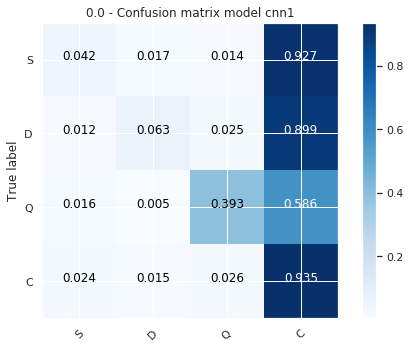

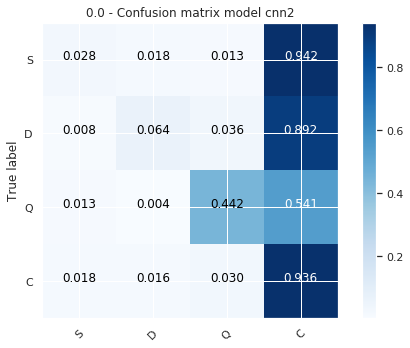

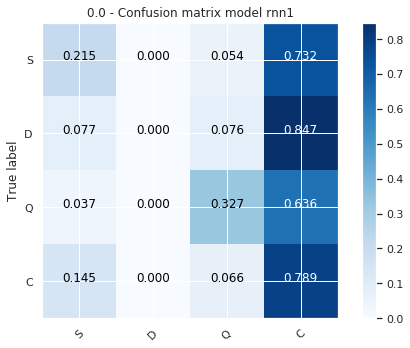

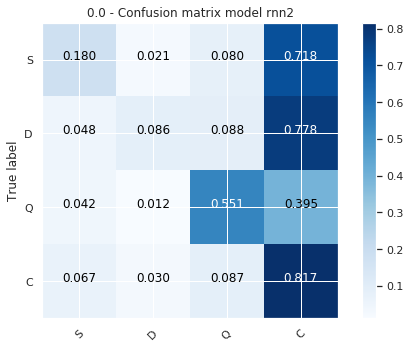

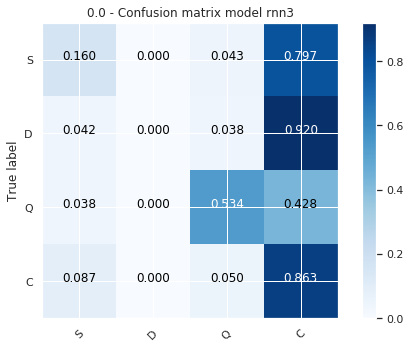

In [54]:
for key in confusions.keys():
    key_cm=np.zeros((4,4))
    temp=confusions[key]
    for confu in temp:
        key_cm+=confu
    plot_cm(cm_norma(key_cm/20.0), ['S', 'D', 'Q', 'C'], title='0.0 - Confusion matrix model '+str(key), cmap='Blues', normalize=True)

In [55]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
#class_weights=np.asarray(class_weights)
## cw de lozano [0.157, 0.396, 0.399, 0.048].
print ("Pesos de clases:", class_weights)

Pesos de clases: [1.26  3.182 3.211 0.388]


In [56]:
fs_macro, fs_none, accs, confusions= train_5models('0.0cw', 20, 10, x_val, y_val, 1, 20, 'Stance', x_train=x_train, y_train=y_train, n_labels=n_labels, class_weights=class_weights)



 -------------------- Entrenando exec 1  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.638
F1-score macro cnn1 : 0.438
F1-score None cnn1 : [0.228 0.18  0.581 0.762]

------ Testing ------
Accuracy cnn2 : 0.548
F1-score macro cnn2 : 0.420
F1-score None cnn2 : [0.167 0.256 0.589 0.667]

------ Testing ------
Accuracy rnn1 : 0.334
F1-score macro rnn1 : 0.334
F1-score None rnn1 : [0.155 0.148 0.631 0.402]

------ Testing ------
Accuracy rnn2 : 0.646
F1-score macro rnn2 : 0.447
F1-score None rnn2 : [0.268 0.237 0.519 0.765]

------ Testing ------
Accuracy rnn3 : 0.147
F1-score macro rnn3 : 0.104
F1-score None rnn3 : [0.    0.095 0.239 0.081]


 -------------------- Entrenando exec 2  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.650
F1-score macro cnn1 : 0.447
F1-score None cnn1 : [0.229 0.25  0.541 0.767]

------ Testing ------
Accuracy cnn2 : 0.646
F1-score macro cnn2 : 0.431
F1-score None cnn2 : [0.191 0.207 0.561 0.765]

------ Testing ------
Acc


------ Testing ------
Accuracy cnn2 : 0.651
F1-score macro cnn2 : 0.424
F1-score None cnn2 : [0.176 0.19  0.564 0.767]

------ Testing ------
Accuracy rnn1 : 0.248
F1-score macro rnn1 : 0.263
F1-score None rnn1 : [0.197 0.183 0.468 0.206]

------ Testing ------
Accuracy rnn2 : 0.748
F1-score macro rnn2 : 0.403
F1-score None rnn2 : [0.104 0.137 0.521 0.849]

------ Testing ------
Accuracy rnn3 : 0.207
F1-score macro rnn3 : 0.203
F1-score None rnn3 : [0.254 0.107 0.238 0.212]


 -------------------- Entrenando exec 14  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.707
F1-score macro cnn1 : 0.430
F1-score None cnn1 : [0.122 0.183 0.6   0.815]

------ Testing ------
Accuracy cnn2 : 0.701
F1-score macro cnn2 : 0.463
F1-score None cnn2 : [0.222 0.224 0.596 0.81 ]

------ Testing ------
Accuracy rnn1 : 0.227
F1-score macro rnn1 : 0.247
F1-score None rnn1 : [0.241 0.168 0.422 0.158]

------ Testing ------
Accuracy rnn2 : 0.712
F1-score macro rnn2 : 0.383
F1-score None rnn2 

In [57]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.0cw - F1-score promedio para",key,":" , temp/20)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.0cw - F1-score macro promedio para",key,":" , temp/20, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.0cw - Accuracy promedio para",key,":", temp/20 , "desvest: ",np.std(accs[key]))
    

0.0cw - F1-score promedio para cnn1 : [0.158 0.2   0.568 0.75 ]
0.0cw - F1-score promedio para cnn2 : [0.158 0.218 0.553 0.75 ]
0.0cw - F1-score promedio para rnn1 : [0.145 0.146 0.407 0.188]
0.0cw - F1-score promedio para rnn2 : [0.173 0.131 0.51  0.828]
0.0cw - F1-score promedio para rnn3 : [0.161 0.139 0.464 0.388]

0.0cw - F1-score macro promedio para cnn1 : 0.4188947030928759 desvest:  0.031584203676027774
0.0cw - F1-score macro promedio para cnn2 : 0.4195817354112482 desvest:  0.02025241286265617
0.0cw - F1-score macro promedio para rnn1 : 0.2212823355860512 desvest:  0.08008809497673727
0.0cw - F1-score macro promedio para rnn2 : 0.41052545675979146 desvest:  0.02535510076604889
0.0cw - F1-score macro promedio para rnn3 : 0.28797498064032584 desvest:  0.08248313519351123

0.0cw - Accuracy promedio para cnn1 : 0.6274730656219394 desvest:  0.04870965696098446
0.0cw - Accuracy promedio para cnn2 : 0.627277179236043 desvest:  0.0467092257803747
0.0cw - Accuracy promedio para rnn1 : 

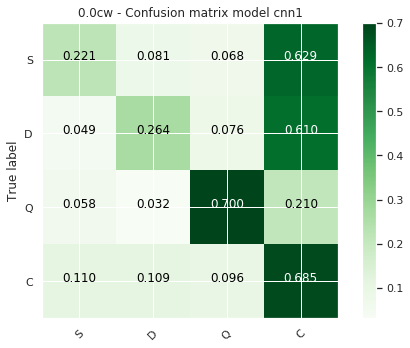

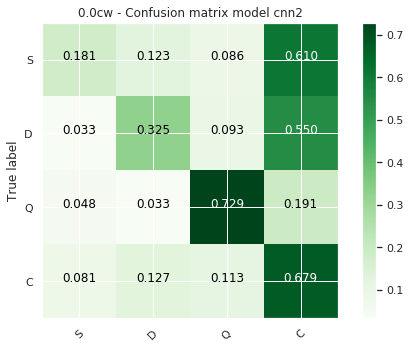

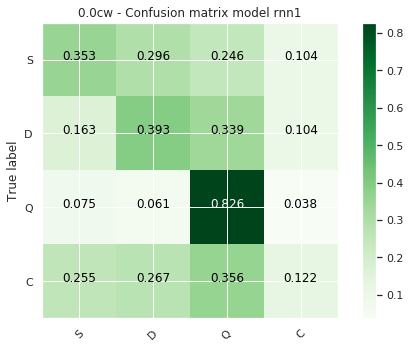

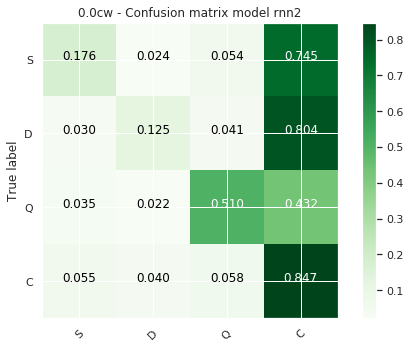

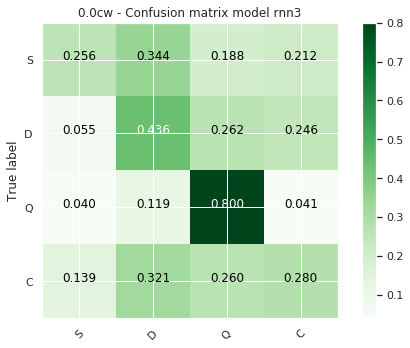

In [58]:
for key in confusions.keys():
    key_cm=np.zeros((4,4))
    temp=confusions[key]
    for confu in temp:
        key_cm+=confu
    plot_cm(cm_norma(key_cm/20.0), ['S', 'D', 'Q', 'C'], title='0.0cw - Confusion matrix model '+str(key), cmap='Greens', normalize=True)

In [ ]:
np.argmax(yes)

def load_data(mask, k):
    macro_augmented = np.load('../Datasets/CSV_Stance/Aumento_ofi/balance_GloVe_'+mask+'_'+str(k)+'_run.npy', allow_pickle=True)
    np.random.shuffle(macro_augmented)

    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    print (np.unique(labels_train), type(labels_train))
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    sentences = tws_train
    n_labels = labels_train.copy()

    input_ids = []
    for sent in sentences:
        encoded_sent = [] 
        for wd in sent:
            try:
                encoded_sent.append(token_2_idx[wd])
            except:
                continue
        input_ids.append(encoded_sent)

    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], emb))
    j=0
    for in_id in input_ids:
        x_train[j]=EMB_matrix[in_id]
        j+=1

    return x_train, y_train, n_labels, class_weights


def train_5models_balanced(fold, k, e1, e2):  #fold es float, #k numero de iter
        
    fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
    mask=str(int(fold*100))
    #for i in range(1,1+k):
    for i in range(1+k,2*k + 1):
        x_train, y_train, n_labels, class_weights = load_data(mask, i)
        print ("\n\n -------------------- Entrenando exec", i," -------------------- \n\n")
        #cnn1=create_cnn1(x_train.shape[1:])
        cnn1=load_model('../Datasets/Models_Stance/'+str(fold)+'/cnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        #trained.save('../Datasets/Models_Stance/'+str(fold)+'/cnn1_'+str(i)+'-exec.h5')   
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn1, x_train, x_val, x_test, n_labels, n_labels_val, n_labels_test, 'cnn1')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['cnn1'].append(f1_ma_t)
        fs_none['cnn1'].append(f1_t)
        accs['cnn1'].append(acc_t)
        confusions['cnn1'].append(matriz_t)

        #cnn2=create_cnn2(x_train.shape[1:])
        cnn2=load_model('../Datasets/Models_Stance/'+str(fold)+'/cnn2_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=True)
        #trained.save('../Datasets/Models_Stance/'+str(fold)+'/cnn2_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(cnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'cnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['cnn2'].append(f1_ma_t)
        fs_none['cnn2'].append(f1_t)
        accs['cnn2'].append(acc_t)
        confusions['cnn2'].append(matriz_t)

        #rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
        rnn1=load_model('../Datasets/Models_Stance/'+str(fold)+'/rnn1_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        #trained.save('../Datasets/Models_Stance/'+str(fold)+'/rnn1_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn1, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn1')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn1'].append(f1_ma_t)
        fs_none['rnn1'].append(f1_t)
        accs['rnn1'].append(acc_t)
        confusions['rnn1'].append(matriz_t)

        #rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
        rnn2=load_model('../Datasets/Models_Stance/'+str(fold)+'/rnn2_'+str(i)+'-exec.h5')
        trained, hist =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=e1, BS=32, verb=0, focal=False)
        #trained.save('../Datasets/Models_Stance/'+str(fold)+'/rnn2_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn2, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn2')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn2'].append(f1_ma_t)
        fs_none['rnn2'].append(f1_t)
        accs['rnn2'].append(acc_t)
        confusions['rnn2'].append(matriz_t)

        #rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
        rnn3=load_model('../Datasets/Models_Stance/'+str(fold)+'/rnn3_'+str(i)+'-exec.h5', custom_objects={'FocalLoss': focal_loss, 'focal_loss_fixed': focal_loss()})
        trained, hist =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=e2, BS=32, verb=0, focal=True)
        #trained.save('../Datasets/Models_Stance/'+str(fold)+'/rnn3_'+str(i)+'-exec.h5')
        f1_ma_t, f1_t, acc_t, matriz_t = predict_data(rnn3, x_train, x_val, x_test,  n_labels, n_labels_val, n_labels_test, 'rnn3')
        keras.backend.clear_session()
        gc.collect()
        
        fs_macro['rnn3'].append(f1_ma_t)
        fs_none['rnn3'].append(f1_t)
        accs['rnn3'].append(acc_t)
        confusions['rnn3'].append(matriz_t)

    return fs_macro, fs_none, accs, confusions

## 15% De 1 - 10

In [33]:
fs_macro, fs_none, accs, confusions= train_5models_balanced(0.15, 10, 8, 4)

[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 



------ Training ------
Accuracy cnn1 : 0.895
F1-score macro cnn1 : 0.895
F1-score None cnn1 : [0.828 0.954 0.973 0.824]

------ Validation ------
Accuracy cnn1 : 0.680
F1-score macro cnn1 : 0.535
F1-score None cnn1 : [0.548 0.222 0.596 0.774]

------ Testing ------
Accuracy cnn1 : 0.689
F1-score macro cnn1 : 0.399
F1-score None cnn1 : [0.019 0.203 0.564 0.809]

------ Training ------
Accuracy cnn2 : 0.877
F1-score macro cnn2 : 0.877
F1-score None cnn2 : [0.823 0.951 0.946 0.789]

------ Validation ------
Accuracy cnn2 : 0.705
F1-score macro cnn2 : 0.593
F1-score None cnn2 : [0.605 0.381 0.597 0.788]

------ Testing ------
Accuracy cnn2 : 0.701
F1-score macro cnn2 : 0.408
F1-score None cnn2 : [0.096 0.154 0.569 0.813]

------ Training ------
Accuracy rnn1 : 0.631
F1-score macro rnn1 : 0.617
F1-score None rnn1 : [0.674 0.506 0.775 0.515]

------ Validation 


------ Training ------
Accuracy cnn2 : 0.866
F1-score macro cnn2 : 0.864
F1-score None cnn2 : [0.768 0.957 0.956 0.775]

------ Validation ------
Accuracy cnn2 : 0.683
F1-score macro cnn2 : 0.571
F1-score None cnn2 : [0.589 0.348 0.583 0.763]

------ Testing ------
Accuracy cnn2 : 0.700
F1-score macro cnn2 : 0.449
F1-score None cnn2 : [0.093 0.25  0.639 0.811]

------ Training ------
Accuracy rnn1 : 0.613
F1-score macro rnn1 : 0.588
F1-score None rnn1 : [0.65  0.647 0.752 0.302]

------ Validation ------
Accuracy rnn1 : 0.420
F1-score macro rnn1 : 0.406
F1-score None rnn1 : [0.519 0.121 0.636 0.349]

------ Testing ------
Accuracy rnn1 : 0.303
F1-score macro rnn1 : 0.327
F1-score None rnn1 : [0.164 0.206 0.612 0.327]

------ Training ------
Accuracy rnn2 : 0.789
F1-score macro rnn2 : 0.793
F1-score None rnn2 : [0.763 0.852 0.887 0.67 ]

------ Validation ------
Accuracy rnn2 : 0.584
F1-score macro rnn2 : 0.511
F1-score None rnn2 : [0.504 0.185 0.667 0.689]

------ Testing ------
Accur


------ Testing ------
Accuracy rnn1 : 0.439
F1-score macro rnn1 : 0.353
F1-score None rnn1 : [0.239 0.215 0.414 0.545]

------ Training ------
Accuracy rnn2 : 0.832
F1-score macro rnn2 : 0.832
F1-score None rnn2 : [0.761 0.899 0.938 0.73 ]

------ Validation ------
Accuracy rnn2 : 0.665
F1-score macro rnn2 : 0.509
F1-score None rnn2 : [0.623 0.069 0.592 0.753]

------ Testing ------
Accuracy rnn2 : 0.667
F1-score macro rnn2 : 0.459
F1-score None rnn2 : [0.243 0.25  0.557 0.785]

------ Training ------
Accuracy rnn3 : 0.662
F1-score macro rnn3 : 0.657
F1-score None rnn3 : [0.68  0.646 0.784 0.518]

------ Validation ------
Accuracy rnn3 : 0.541
F1-score macro rnn3 : 0.475
F1-score None rnn3 : [0.565 0.118 0.639 0.58 ]

------ Testing ------
Accuracy rnn3 : 0.454
F1-score macro rnn3 : 0.373
F1-score None rnn3 : [0.224 0.185 0.509 0.573]
[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 10  -------------------- 



------ Training --

In [34]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 - F1-score promedio para",key,":" , temp/10)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 - F1-score macro promedio para",key,":" , temp/10, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 - Accuracy promedio para",key,":", temp/10 , "desvest: ",np.std(accs[key]))
    

0.15 - F1-score promedio para cnn1 : [0.109 0.199 0.562 0.811]
0.15 - F1-score promedio para cnn2 : [0.119 0.183 0.589 0.814]
0.15 - F1-score promedio para rnn1 : [0.204 0.208 0.454 0.477]
0.15 - F1-score promedio para rnn2 : [0.201 0.214 0.524 0.729]
0.15 - F1-score promedio para rnn3 : [0.166 0.198 0.471 0.503]

0.15 - F1-score macro promedio para cnn1 : 0.42022685747066096 desvest:  0.021157965677602975
0.15 - F1-score macro promedio para cnn2 : 0.42635661433130123 desvest:  0.018852906974126248
0.15 - F1-score macro promedio para rnn1 : 0.33587069785278867 desvest:  0.03727255441697077
0.15 - F1-score macro promedio para rnn2 : 0.4170264703843832 desvest:  0.02419203743091565
0.15 - F1-score macro promedio para rnn3 : 0.3343655917705837 desvest:  0.03858020753727795

0.15 - Accuracy promedio para cnn1 : 0.6964740450538688 desvest:  0.03792425692123494
0.15 - Accuracy promedio para cnn2 : 0.7006856023506366 desvest:  0.027658158816411833
0.15 - Accuracy promedio para rnn1 : 0.395690

In [ ]:
0.15 - F1-score promedio para cnn1 : [0.084 0.189 0.578 0.827]
0.15 - F1-score promedio para cnn2 : [0.08  0.235 0.565 0.813]
0.15 - F1-score promedio para rnn1 : [0.188 0.193 0.453 0.645]
0.15 - F1-score promedio para rnn2 : [0.139 0.21  0.486 0.707]
0.15 - F1-score promedio para rnn3 : [0.185 0.216 0.485 0.658]

0.15 - F1-score macro promedio para cnn1 : 0.4192007021997456 desvest:  0.01616017471988819
0.15 - F1-score macro promedio para cnn2 : 0.4232225379963527 desvest:  0.01450721987058891
0.15 - F1-score macro promedio para rnn1 : 0.3697950165577151 desvest:  0.0313093338876847
0.15 - F1-score macro promedio para rnn2 : 0.3853513899529677 desvest:  0.01929819286734307
0.15 - F1-score macro promedio para rnn3 : 0.386019968619015 desvest:  0.023981828736258683

0.15 - Accuracy promedio para cnn1 : 0.7169441723800196 desvest:  0.021887619333784303
0.15 - Accuracy promedio para cnn2 : 0.6967678746327131 desvest:  0.02639092010774747
0.15 - Accuracy promedio para rnn1 : 0.5181194906953966 desvest:  0.10244689436292287
0.15 - Accuracy promedio para rnn2 : 0.5705190989226249 desvest:  0.06242947060398407
0.15 - Accuracy promedio para rnn3 : 0.5312438785504406 desvest:  0.07443708438534685

In [20]:
import numpy as np 

a=np.asarray([0.166 ,0.198 ,0.471, 0.503])
b=np.asarray([0.185 ,0.216 ,0.485, 0.658])
( 0.021887619333784303 + 0.03792425692123494 )/2

0.02990593812750962

## 15% De 11 - 20

In [17]:
class_weights

[1.0, 1.0, 1.0, 1.0]

In [18]:
fs_macro, fs_none, accs, confusions= train_5models_balanced(0.15, 10, 8, 4)

[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 11  -------------------- 







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

------ Training ------
Accuracy cnn1 : 0.957
F1-score macro cnn1 : 0.957
F1-score None cnn1 : [0.925 0.992 0.99  0.92 ]

------ Validation ------
Accuracy cnn1 : 0.726
F1-score macro cnn1 : 0.535
F1-score None cnn1 : [0.632 0.133 0.566 0.809]

------ Testing ------
Accuracy cnn1 : 0.747
F1-score macro cnn1 : 0.415
F1-score None cnn1 : [0.055 0.189 0.566 0.849]

------ Training ------
Accuracy cnn2 : 0.949
F1-score macro cnn2 : 0.949
F1-score None cnn2 : [0.922 0.98  0.984 0.911]

------ Validation ------
Accuracy cnn2 : 0.658
F1-score macro cnn2 : 0.534
F1-score None cnn2 : [0.557 0.222 0.593 0.762]

------ Testing ------
Accuracy cnn2 : 0.68



 -------------------- Entrenando exec 14  -------------------- 



------ Training ------
Accuracy cnn1 : 0.940
F1-score macro cnn1 : 0.940
F1-score None cnn1 : [0.897 0.982 0.983 0.897]

------ Validation ------
Accuracy cnn1 : 0.733
F1-score macro cnn1 : 0.617
F1-score None cnn1 : [0.65  0.385 0.625 0.808]

------ Testing ------
Accuracy cnn1 : 0.704
F1-score macro cnn1 : 0.428
F1-score None cnn1 : [0.061 0.258 0.578 0.817]

------ Training ------
Accuracy cnn2 : 0.955
F1-score macro cnn2 : 0.955
F1-score None cnn2 : [0.937 0.982 0.983 0.92 ]

------ Validation ------
Accuracy cnn2 : 0.687
F1-score macro cnn2 : 0.554
F1-score None cnn2 : [0.6   0.273 0.576 0.768]

------ Testing ------
Accuracy cnn2 : 0.700
F1-score macro cnn2 : 0.445
F1-score None cnn2 : [0.119 0.255 0.595 0.813]

------ Training ------
Accuracy rnn1 : 0.682
F1-score macro rnn1 : 0.677
F1-score None rnn1 : [0.696 0.696 0.792 0.524]

------ Validation ------
Accuracy rnn1 : 0.423
F1-score macro rnn1 : 0.401
F1-scor


------ Training ------
Accuracy cnn2 : 0.954
F1-score macro cnn2 : 0.954
F1-score None cnn2 : [0.929 0.987 0.984 0.917]

------ Validation ------
Accuracy cnn2 : 0.705
F1-score macro cnn2 : 0.567
F1-score None cnn2 : [0.58  0.273 0.623 0.793]

------ Testing ------
Accuracy cnn2 : 0.698
F1-score macro cnn2 : 0.404
F1-score None cnn2 : [0.033 0.222 0.549 0.812]

------ Training ------
Accuracy rnn1 : 0.649
F1-score macro rnn1 : 0.641
F1-score None rnn1 : [0.605 0.474 0.904 0.581]

------ Validation ------
Accuracy rnn1 : 0.690
F1-score macro rnn1 : 0.473
F1-score None rnn1 : [0.495 0.    0.609 0.789]

------ Testing ------
Accuracy rnn1 : 0.744
F1-score macro rnn1 : 0.411
F1-score None rnn1 : [0.085 0.151 0.561 0.846]

------ Training ------
Accuracy rnn2 : 0.935
F1-score macro rnn2 : 0.934
F1-score None rnn2 : [0.92  0.959 0.977 0.881]

------ Validation ------
Accuracy rnn2 : 0.580
F1-score macro rnn2 : 0.469
F1-score None rnn2 : [0.459 0.154 0.597 0.667]

------ Testing ------
Accur

In [19]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.15 - F1-score promedio para",key,":" , temp/10)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.15 - F1-score macro promedio para",key,":" , temp/10, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.15 - Accuracy promedio para",key,":", temp/10 , "desvest: ",np.std(accs[key]))
    

0.15 - F1-score promedio para cnn1 : [0.084 0.189 0.578 0.827]
0.15 - F1-score promedio para cnn2 : [0.08  0.235 0.565 0.813]
0.15 - F1-score promedio para rnn1 : [0.188 0.193 0.453 0.645]
0.15 - F1-score promedio para rnn2 : [0.139 0.21  0.486 0.707]
0.15 - F1-score promedio para rnn3 : [0.185 0.216 0.485 0.658]

0.15 - F1-score macro promedio para cnn1 : 0.4192007021997456 desvest:  0.01616017471988819
0.15 - F1-score macro promedio para cnn2 : 0.4232225379963527 desvest:  0.01450721987058891
0.15 - F1-score macro promedio para rnn1 : 0.3697950165577151 desvest:  0.0313093338876847
0.15 - F1-score macro promedio para rnn2 : 0.3853513899529677 desvest:  0.01929819286734307
0.15 - F1-score macro promedio para rnn3 : 0.386019968619015 desvest:  0.023981828736258683

0.15 - Accuracy promedio para cnn1 : 0.7169441723800196 desvest:  0.021887619333784303
0.15 - Accuracy promedio para cnn2 : 0.6967678746327131 desvest:  0.02639092010774747
0.15 - Accuracy promedio para rnn1 : 0.518119490695

## 50% De 1 - 10

In [35]:
fs_macro, fs_none, accs, confusions= train_5models_balanced(0.5, 10, 8, 4)

[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 



------ Training ------
Accuracy cnn1 : 0.891
F1-score macro cnn1 : 0.891
F1-score None cnn1 : [0.821 0.949 0.972 0.823]

------ Validation ------
Accuracy cnn1 : 0.708
F1-score macro cnn1 : 0.580
F1-score None cnn1 : [0.61  0.316 0.607 0.786]

------ Testing ------
Accuracy cnn1 : 0.708
F1-score macro cnn1 : 0.434
F1-score None cnn1 : [0.14  0.206 0.57  0.819]

------ Training ------
Accuracy cnn2 : 0.884
F1-score macro cnn2 : 0.884
F1-score None cnn2 : [0.819 0.948 0.965 0.804]

------ Validation ------
Accuracy cnn2 : 0.669
F1-score macro cnn2 : 0.553
F1-score None cnn2 : [0.597 0.25  0.623 0.743]

------ Testing ------
Accuracy cnn2 : 0.657
F1-score macro cnn2 : 0.421
F1-score None cnn2 : [0.145 0.218 0.541 0.781]

------ Training ------
Accuracy rnn1 : 0.558
F1-score macro rnn1 : 0.540
F1-score None rnn1 : [0.628 0.44  0.739 0.354]

------ Validation 


------ Training ------
Accuracy cnn2 : 0.868
F1-score macro cnn2 : 0.866
F1-score None cnn2 : [0.788 0.944 0.953 0.778]

------ Validation ------
Accuracy cnn2 : 0.630
F1-score macro cnn2 : 0.532
F1-score None cnn2 : [0.561 0.238 0.615 0.715]

------ Testing ------
Accuracy cnn2 : 0.635
F1-score macro cnn2 : 0.404
F1-score None cnn2 : [0.047 0.237 0.577 0.756]

------ Training ------
Accuracy rnn1 : 0.594
F1-score macro rnn1 : 0.588
F1-score None rnn1 : [0.644 0.505 0.753 0.451]

------ Validation ------
Accuracy rnn1 : 0.552
F1-score macro rnn1 : 0.506
F1-score None rnn1 : [0.497 0.296 0.638 0.593]

------ Testing ------
Accuracy rnn1 : 0.493
F1-score macro rnn1 : 0.382
F1-score None rnn1 : [0.169 0.234 0.513 0.612]

------ Training ------
Accuracy rnn2 : 0.767
F1-score macro rnn2 : 0.755
F1-score None rnn2 : [0.733 0.811 0.868 0.608]

------ Validation ------
Accuracy rnn2 : 0.477
F1-score macro rnn2 : 0.440
F1-score None rnn2 : [0.543 0.205 0.494 0.517]

------ Testing ------
Accur


------ Testing ------
Accuracy rnn1 : 0.305
F1-score macro rnn1 : 0.299
F1-score None rnn1 : [0.23  0.176 0.452 0.337]

------ Training ------
Accuracy rnn2 : 0.809
F1-score macro rnn2 : 0.811
F1-score None rnn2 : [0.778 0.86  0.919 0.685]

------ Validation ------
Accuracy rnn2 : 0.609
F1-score macro rnn2 : 0.496
F1-score None rnn2 : [0.586 0.125 0.594 0.678]

------ Testing ------
Accuracy rnn2 : 0.586
F1-score macro rnn2 : 0.427
F1-score None rnn2 : [0.23  0.205 0.554 0.719]

------ Training ------
Accuracy rnn3 : 0.518
F1-score macro rnn3 : 0.480
F1-score None rnn3 : [0.583 0.603 0.598 0.136]

------ Validation ------
Accuracy rnn3 : 0.299
F1-score macro rnn3 : 0.307
F1-score None rnn3 : [0.436 0.107 0.542 0.143]

------ Testing ------
Accuracy rnn3 : 0.188
F1-score macro rnn3 : 0.240
F1-score None rnn3 : [0.166 0.194 0.448 0.151]
[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 10  -------------------- 



------ Training --

In [36]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.5 - F1-score promedio para",key,":" , temp/10)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.5 - F1-score macro promedio para",key,":" , temp/10, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.5 - Accuracy promedio para",key,":", temp/10 , "desvest: ",np.std(accs[key]))
    

0.5 - F1-score promedio para cnn1 : [0.101 0.201 0.558 0.8  ]
0.5 - F1-score promedio para cnn2 : [0.092 0.226 0.566 0.785]
0.5 - F1-score promedio para rnn1 : [0.183 0.184 0.497 0.435]
0.5 - F1-score promedio para rnn2 : [0.168 0.215 0.49  0.616]
0.5 - F1-score promedio para rnn3 : [0.153 0.198 0.451 0.507]

0.5 - F1-score macro promedio para cnn1 : 0.4152549318099966 desvest:  0.011300300603882615
0.5 - F1-score macro promedio para cnn2 : 0.4173040518938874 desvest:  0.010908337866118932
0.5 - F1-score macro promedio para rnn1 : 0.3246983531398174 desvest:  0.03653894519291251
0.5 - F1-score macro promedio para rnn2 : 0.37257142751720956 desvest:  0.05264149657722306
0.5 - F1-score macro promedio para rnn3 : 0.3271544604572575 desvest:  0.056708407043371545

0.5 - Accuracy promedio para cnn1 : 0.6831537708129284 desvest:  0.04073365432103272
0.5 - Accuracy promedio para cnn2 : 0.666405484818805 desvest:  0.03300903569618706
0.5 - Accuracy promedio para rnn1 : 0.36199804113614104 desv

In [ ]:
0.5 - Accuracy promedio para cnn1 : 0.6646425073457395 desvest:  0.04503938786999346
0.5 - Accuracy promedio para cnn2 : 0.6630754162585701 desvest:  0.04212696017160933
0.5 - Accuracy promedio para rnn1 : 0.3626836434867777 desvest:  0.16261168856408664
0.5 - Accuracy promedio para rnn2 : 0.48041136141038204 desvest:  0.1408321285409304
0.5 - Accuracy promedio para rnn3 : 0.36895200783545545 desvest:  0.11384525946216509

In [25]:
a=np.asarray([0.153 ,0.198 ,0.451 ,0.507])
b=np.asarray([0.152 ,0.165 ,0.456 ,0.444])

#( 0.03858020753727795 + 0.023981828736258683 )/2
(a + b)/2

array([0.1525, 0.1815, 0.4535, 0.4755])

## 50% De 11 - 20

In [17]:
fs_macro, fs_none, accs, confusions= train_5models(0.5, 8, 4, x_val, y_val, 11, 20, 'Stance', balanced=True)

[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 11  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.683
F1-score macro cnn1 : 0.420
F1-score None cnn1 : [0.153 0.144 0.585 0.797]

------ Testing ------
Accuracy cnn2 : 0.633
F1-score macro cnn2 : 0.427
F1-score None cnn2 : [0.146 0.226 0.576 0.759]

------ Testing ------
Accuracy rnn1 : 0.502
F1-score macro rnn1 : 0.359
F1-score None rnn1 : [0.203 0.178 0.425 0.633]

------ Testing ------
Accuracy rnn2 : 0.663
F1-score macro rnn2 : 0.365
F1-score None rnn2 : [0.094 0.196 0.373 0.796]

------ Testing ------
Accuracy rnn3 : 0.585
F1-score macro rnn3 : 0.310
F1-score None rnn3 : [0.049 0.107 0.356 0.727]
[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 12  -------------------- 



------ Testing ------
Accuracy cnn1 : 0.665
F1-score macro cnn1 : 0.423
F1-score None cnn1 : [0.085 0.205 0.617 0.785]

------ Testin

In [18]:
#(fold, e1, e2, x_val, y_val, xfrom, xto, MAX_LEN, task, balanced=False, x_train=None, y_train=None, n_labels=None, class_weights=None)
### 11 - 20


for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.5 - F1-score promedio para",key,":" , temp/10)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.5 - F1-score macro promedio para",key,":" , temp/10, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.5 - Accuracy promedio para",key,":", temp/10 , "desvest: ",np.std(accs[key]))
    

0.5 - F1-score promedio para cnn1 : [0.109 0.201 0.574 0.784]
0.5 - F1-score promedio para cnn2 : [0.099 0.225 0.579 0.783]
0.5 - F1-score promedio para rnn1 : [0.164 0.158 0.401 0.421]
0.5 - F1-score promedio para rnn2 : [0.129 0.182 0.471 0.593]
0.5 - F1-score promedio para rnn3 : [0.152 0.165 0.456 0.444]

0.5 - F1-score macro promedio para cnn1 : 0.4172013909486922 desvest:  0.012665108966502263
0.5 - F1-score macro promedio para cnn2 : 0.42136108311114173 desvest:  0.014096345902233045
0.5 - F1-score macro promedio para rnn1 : 0.28595507793068353 desvest:  0.09732257187513861
0.5 - F1-score macro promedio para rnn2 : 0.34374157387412557 desvest:  0.04429250963600034
0.5 - F1-score macro promedio para rnn3 : 0.3042592221663802 desvest:  0.03149733362923091

0.5 - Accuracy promedio para cnn1 : 0.6646425073457395 desvest:  0.04503938786999346
0.5 - Accuracy promedio para cnn2 : 0.6630754162585701 desvest:  0.04212696017160933
0.5 - Accuracy promedio para rnn1 : 0.3626836434867777 des

## 85% De 1 - 10

In [37]:
fs_macro, fs_none, accs, confusions= train_5models_balanced(0.85, 10, 8, 4)

[0 1 2 3] <class 'numpy.ndarray'>
Pesos de clases: [1. 1. 1. 1.]


 -------------------- Entrenando exec 1  -------------------- 



------ Training ------
Accuracy cnn1 : 0.891
F1-score macro cnn1 : 0.892
F1-score None cnn1 : [0.831 0.953 0.966 0.819]

------ Validation ------
Accuracy cnn1 : 0.690
F1-score macro cnn1 : 0.522
F1-score None cnn1 : [0.565 0.118 0.632 0.773]

------ Testing ------
Accuracy cnn1 : 0.702
F1-score macro cnn1 : 0.405
F1-score None cnn1 : [0.085 0.179 0.537 0.82 ]

------ Training ------
Accuracy cnn2 : 0.860
F1-score macro cnn2 : 0.856
F1-score None cnn2 : [0.784 0.894 0.957 0.789]

------ Validation ------
Accuracy cnn2 : 0.683
F1-score macro cnn2 : 0.585
F1-score None cnn2 : [0.6   0.286 0.687 0.768]

------ Testing ------
Accuracy cnn2 : 0.596
F1-score macro cnn2 : 0.423
F1-score None cnn2 : [0.14  0.235 0.598 0.721]

------ Training ------
Accuracy rnn1 : 0.472
F1-score macro rnn1 : 0.401
F1-score None rnn1 : [0.529 0.194 0.781 0.101]

------ Validation 


------ Training ------
Accuracy cnn2 : 0.882
F1-score macro cnn2 : 0.880
F1-score None cnn2 : [0.823 0.928 0.958 0.811]

------ Validation ------
Accuracy cnn2 : 0.698
F1-score macro cnn2 : 0.573
F1-score None cnn2 : [0.588 0.242 0.667 0.794]

------ Testing ------
Accuracy cnn2 : 0.618
F1-score macro cnn2 : 0.414
F1-score None cnn2 : [0.141 0.225 0.548 0.743]

------ Training ------
Accuracy rnn1 : 0.608
F1-score macro rnn1 : 0.608
F1-score None rnn1 : [0.647 0.556 0.755 0.474]

------ Validation ------
Accuracy rnn1 : 0.580
F1-score macro rnn1 : 0.494
F1-score None rnn1 : [0.548 0.154 0.645 0.628]

------ Testing ------
Accuracy rnn1 : 0.449
F1-score macro rnn1 : 0.363
F1-score None rnn1 : [0.171 0.173 0.531 0.576]

------ Training ------
Accuracy rnn2 : 0.714
F1-score macro rnn2 : 0.706
F1-score None rnn2 : [0.592 0.79  0.776 0.666]

------ Validation ------
Accuracy rnn2 : 0.598
F1-score macro rnn2 : 0.402
F1-score None rnn2 : [0.408 0.    0.476 0.724]

------ Testing ------
Accur


------ Validation ------
Accuracy rnn1 : 0.402
F1-score macro rnn1 : 0.413
F1-score None rnn1 : [0.513 0.116 0.513 0.51 ]

------ Testing ------
Accuracy rnn1 : 0.274
F1-score macro rnn1 : 0.232
F1-score None rnn1 : [0.05  0.154 0.336 0.389]

------ Training ------
Accuracy rnn2 : 0.822
F1-score macro rnn2 : 0.823
F1-score None rnn2 : [0.778 0.829 0.928 0.757]

------ Validation ------
Accuracy rnn2 : 0.705
F1-score macro rnn2 : 0.516
F1-score None rnn2 : [0.636 0.    0.646 0.783]

------ Testing ------
Accuracy rnn2 : 0.660
F1-score macro rnn2 : 0.364
F1-score None rnn2 : [0.109 0.122 0.437 0.791]

------ Training ------
Accuracy rnn3 : 0.691
F1-score macro rnn3 : 0.688
F1-score None rnn3 : [0.651 0.646 0.812 0.642]

------ Validation ------
Accuracy rnn3 : 0.687
F1-score macro rnn3 : 0.519
F1-score None rnn3 : [0.56  0.083 0.648 0.784]

------ Testing ------
Accuracy rnn3 : 0.657
F1-score macro rnn3 : 0.391
F1-score None rnn3 : [0.074 0.174 0.535 0.783]
[0 1 2 3] <class 'numpy.ndarr

In [38]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.85 - F1-score promedio para",key,":" , temp/10)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.85 - F1-score macro promedio para",key,":" , temp/10, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.85 - Accuracy promedio para",key,":", temp/10 , "desvest: ",np.std(accs[key]))
    

0.85 - F1-score promedio para cnn1 : [0.076 0.195 0.522 0.809]
0.85 - F1-score promedio para cnn2 : [0.099 0.209 0.56  0.795]
0.85 - F1-score promedio para rnn1 : [0.142 0.153 0.418 0.416]
0.85 - F1-score promedio para rnn2 : [0.127 0.165 0.426 0.714]
0.85 - F1-score promedio para rnn3 : [0.176 0.17  0.447 0.527]

0.85 - F1-score macro promedio para cnn1 : 0.4003995441184792 desvest:  0.011601102053806212
0.85 - F1-score macro promedio para cnn2 : 0.4159982060086902 desvest:  0.012802216429697824
0.85 - F1-score macro promedio para rnn1 : 0.2821754812181269 desvest:  0.07014588616143995
0.85 - F1-score macro promedio para rnn2 : 0.358010143827124 desvest:  0.012090791677495006
0.85 - F1-score macro promedio para rnn3 : 0.32994511860483133 desvest:  0.04473069762537621

0.85 - Accuracy promedio para cnn1 : 0.6932419196865818 desvest:  0.025573490962378195
0.85 - Accuracy promedio para cnn2 : 0.6784524975514202 desvest:  0.04570296378462062
0.85 - Accuracy promedio para rnn1 : 0.34378060

In [ ]:
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------

# Dropout normal - 0.65

In [19]:
class_weights

[1.0, 1.0, 1.0, 1.0]

In [20]:
fs_macro, fs_none, accs, confusions= train_5models(10, '0.0', x_train, y_train, n_labels, class_weights, 20, 10)



 -------------------- Entrenando exec 1  -------------------- 



------ Training ------
Accuracy cnn1 : 0.769
F1-score macro cnn1 : 0.633
F1-score None cnn1 : [0.642 0.374 0.672 0.843]

------ Validation ------
Accuracy cnn1 : 0.726
F1-score macro cnn1 : 0.572
F1-score None cnn1 : [0.513 0.222 0.741 0.812]

------ Testing ------
Accuracy cnn1 : 0.754
F1-score macro cnn1 : 0.403
F1-score None cnn1 : [0.067 0.092 0.598 0.853]

------ Training ------
Accuracy cnn2 : 0.725
F1-score macro cnn2 : 0.469
F1-score None cnn2 : [0.393 0.    0.66  0.824]

------ Validation ------
Accuracy cnn2 : 0.673
F1-score macro cnn2 : 0.399
F1-score None cnn2 : [0.182 0.    0.63  0.786]

------ Testing ------
Accuracy cnn2 : 0.795
F1-score macro cnn2 : 0.380
F1-score None cnn2 : [0.    0.    0.64  0.879]

------ Training ------
Accuracy rnn1 : 0.197
F1-score macro rnn1 : 0.194
F1-score None rnn1 : [0.46  0.    0.174 0.141]

------ Validation ------
Accuracy rnn1 : 0.238
F1-score macro rnn1 : 0.204
F1-score


------ Testing ------
Accuracy cnn2 : 0.791
F1-score macro cnn2 : 0.362
F1-score None cnn2 : [0.    0.    0.571 0.878]

------ Training ------
Accuracy rnn1 : 0.645
F1-score macro rnn1 : 0.196
F1-score None rnn1 : [0.    0.    0.    0.784]

------ Validation ------
Accuracy rnn1 : 0.616
F1-score macro rnn1 : 0.191
F1-score None rnn1 : [0.    0.    0.    0.762]

------ Testing ------
Accuracy rnn1 : 0.762
F1-score macro rnn1 : 0.216
F1-score None rnn1 : [0.    0.    0.    0.865]

------ Training ------
Accuracy rnn2 : 0.720
F1-score macro rnn2 : 0.486
F1-score None rnn2 : [0.634 0.    0.481 0.829]

------ Validation ------
Accuracy rnn2 : 0.694
F1-score macro rnn2 : 0.488
F1-score None rnn2 : [0.565 0.    0.608 0.782]

------ Testing ------
Accuracy rnn2 : 0.702
F1-score macro rnn2 : 0.387
F1-score None rnn2 : [0.256 0.    0.473 0.819]

------ Training ------
Accuracy rnn3 : 0.357
F1-score macro rnn3 : 0.302
F1-score None rnn3 : [0.591 0.    0.215 0.402]

------ Validation ------
Accur


------ Testing ------
Accuracy rnn2 : 0.740
F1-score macro rnn2 : 0.332
F1-score None rnn2 : [0.114 0.    0.366 0.847]

------ Training ------
Accuracy rnn3 : 0.642
F1-score macro rnn3 : 0.450
F1-score None rnn3 : [0.541 0.    0.518 0.741]

------ Validation ------
Accuracy rnn3 : 0.690
F1-score macro rnn3 : 0.516
F1-score None rnn3 : [0.601 0.    0.704 0.757]

------ Testing ------
Accuracy rnn3 : 0.670
F1-score macro rnn3 : 0.402
F1-score None rnn3 : [0.218 0.    0.604 0.788]


 -------------------- Entrenando exec 10  -------------------- 



------ Training ------
Accuracy cnn1 : 0.724
F1-score macro cnn1 : 0.478
F1-score None cnn1 : [0.448 0.012 0.628 0.824]

------ Validation ------
Accuracy cnn1 : 0.669
F1-score macro cnn1 : 0.390
F1-score None cnn1 : [0.16  0.    0.613 0.787]

------ Testing ------
Accuracy cnn1 : 0.771
F1-score macro cnn1 : 0.362
F1-score None cnn1 : [0.    0.    0.583 0.865]

------ Training ------
Accuracy cnn2 : 0.745
F1-score macro cnn2 : 0.489
F1-score N

In [21]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.0 - F1-score promedio para",key,":" , temp/10)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.0 - F1-score macro promedio para",key,":" , temp/10, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.0 - Accuracy promedio para",key,":", temp/10 , "desvest: ",np.std(accs[key]))
    

0.0 - F1-score promedio para cnn1 : [0.024 0.021 0.568 0.868]
0.0 - F1-score promedio para cnn2 : [0.007 0.    0.591 0.876]
0.0 - F1-score promedio para rnn1 : [0.04  0.    0.167 0.779]
0.0 - F1-score promedio para rnn2 : [0.18  0.038 0.481 0.837]
0.0 - F1-score promedio para rnn3 : [0.166 0.    0.411 0.747]

0.0 - F1-score macro promedio para cnn1 : 0.37019646481579305 desvest:  0.020190529707242447
0.0 - F1-score macro promedio para cnn2 : 0.36853662699175205 desvest:  0.009829008142514091
0.0 - F1-score macro promedio para rnn1 : 0.24627580383315256 desvest:  0.07392118322480047
0.0 - F1-score macro promedio para rnn2 : 0.3842379539630598 desvest:  0.025002269211470984
0.0 - F1-score macro promedio para rnn3 : 0.3310551285002259 desvest:  0.07552406934641462

0.0 - Accuracy promedio para cnn1 : 0.7760039177277178 desvest:  0.012504933358493911
0.0 - Accuracy promedio para cnn2 : 0.7885406464250735 desvest:  0.005443562480544657
0.0 - Accuracy promedio para rnn1 : 0.6824681684622919 

In [22]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
#class_weights=np.asarray(class_weights)
## cw de lozano [0.157, 0.396, 0.399, 0.048].
print ("Pesos de clases:", class_weights)

Pesos de clases: [1.26  3.182 3.211 0.388]


In [23]:
fs_macro, fs_none, accs, confusions= train_5models(10, '0.0cw', x_train, y_train, n_labels, class_weights, 20, 10)



 -------------------- Entrenando exec 1  -------------------- 



------ Training ------
Accuracy cnn1 : 0.669
F1-score macro cnn1 : 0.605
F1-score None cnn1 : [0.594 0.434 0.646 0.744]

------ Validation ------
Accuracy cnn1 : 0.665
F1-score macro cnn1 : 0.549
F1-score None cnn1 : [0.559 0.222 0.647 0.767]

------ Testing ------
Accuracy cnn1 : 0.618
F1-score macro cnn1 : 0.413
F1-score None cnn1 : [0.073 0.215 0.613 0.75 ]

------ Training ------
Accuracy cnn2 : 0.520
F1-score macro cnn2 : 0.488
F1-score None cnn2 : [0.554 0.262 0.544 0.592]

------ Validation ------
Accuracy cnn2 : 0.530
F1-score macro cnn2 : 0.427
F1-score None cnn2 : [0.294 0.185 0.575 0.652]

------ Testing ------
Accuracy cnn2 : 0.506
F1-score macro cnn2 : 0.360
F1-score None cnn2 : [0.042 0.175 0.588 0.634]

------ Training ------
Accuracy rnn1 : 0.381
F1-score macro rnn1 : 0.403
F1-score None rnn1 : [0.504 0.218 0.531 0.36 ]

------ Validation ------
Accuracy rnn1 : 0.431
F1-score macro rnn1 : 0.428
F1-score


------ Testing ------
Accuracy cnn2 : 0.422
F1-score macro cnn2 : 0.307
F1-score None cnn2 : [0.072 0.156 0.463 0.535]

------ Training ------
Accuracy rnn1 : 0.236
F1-score macro rnn1 : 0.263
F1-score None rnn1 : [0.422 0.157 0.472 0.   ]

------ Validation ------
Accuracy rnn1 : 0.292
F1-score macro rnn1 : 0.296
F1-score None rnn1 : [0.495 0.067 0.623 0.   ]

------ Testing ------
Accuracy rnn1 : 0.168
F1-score macro rnn1 : 0.234
F1-score None rnn1 : [0.163 0.175 0.597 0.   ]

------ Training ------
Accuracy rnn2 : 0.765
F1-score macro rnn2 : 0.536
F1-score None rnn2 : [0.689 0.    0.607 0.847]

------ Validation ------
Accuracy rnn2 : 0.719
F1-score macro rnn2 : 0.502
F1-score None rnn2 : [0.627 0.    0.581 0.8  ]

------ Testing ------
Accuracy rnn2 : 0.748
F1-score macro rnn2 : 0.411
F1-score None rnn2 : [0.224 0.    0.57  0.849]

------ Training ------
Accuracy rnn3 : 0.237
F1-score macro rnn3 : 0.285
F1-score None rnn3 : [0.456 0.164 0.52  0.   ]

------ Validation ------
Accur


------ Testing ------
Accuracy rnn2 : 0.725
F1-score macro rnn2 : 0.395
F1-score None rnn2 : [0.239 0.025 0.484 0.833]

------ Training ------
Accuracy rnn3 : 0.291
F1-score macro rnn3 : 0.289
F1-score None rnn3 : [0.489 0.175 0.325 0.166]

------ Validation ------
Accuracy rnn3 : 0.374
F1-score macro rnn3 : 0.346
F1-score None rnn3 : [0.559 0.116 0.477 0.232]

------ Testing ------
Accuracy rnn3 : 0.220
F1-score macro rnn3 : 0.216
F1-score None rnn3 : [0.206 0.125 0.363 0.171]


 -------------------- Entrenando exec 10  -------------------- 



------ Training ------
Accuracy cnn1 : 0.642
F1-score macro cnn1 : 0.586
F1-score None cnn1 : [0.595 0.41  0.623 0.716]

------ Validation ------
Accuracy cnn1 : 0.619
F1-score macro cnn1 : 0.526
F1-score None cnn1 : [0.542 0.204 0.658 0.702]

------ Testing ------
Accuracy cnn1 : 0.589
F1-score macro cnn1 : 0.398
F1-score None cnn1 : [0.059 0.215 0.604 0.714]

------ Training ------
Accuracy cnn2 : 0.446
F1-score macro cnn2 : 0.426
F1-score N

In [24]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.0cw - F1-score promedio para",key,":" , temp/10)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.0cw - F1-score macro promedio para",key,":" , temp/10, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.0cw - Accuracy promedio para",key,":", temp/10 , "desvest: ",np.std(accs[key]))
    

0.0cw - F1-score promedio para cnn1 : [0.142 0.193 0.598 0.746]
0.0cw - F1-score promedio para cnn2 : [0.158 0.189 0.464 0.618]
0.0cw - F1-score promedio para rnn1 : [0.167 0.166 0.538 0.226]
0.0cw - F1-score promedio para rnn2 : [0.186 0.078 0.477 0.812]
0.0cw - F1-score promedio para rnn3 : [0.207 0.127 0.43  0.435]

0.0cw - F1-score macro promedio para cnn1 : 0.41977642649153885 desvest:  0.031489677274745095
0.0cw - F1-score macro promedio para cnn2 : 0.357311864900698 desvest:  0.03909397472312574
0.0cw - F1-score macro promedio para rnn1 : 0.27438304221583487 desvest:  0.03416421361554242
0.0cw - F1-score macro promedio para rnn2 : 0.3883612728165267 desvest:  0.018082626767245914
0.0cw - F1-score macro promedio para rnn3 : 0.299749259337995 desvest:  0.06461355526311358

0.0cw - Accuracy promedio para cnn1 : 0.6234084231145935 desvest:  0.05630881850167522
0.0cw - Accuracy promedio para cnn2 : 0.49980411361410376 desvest:  0.07452576005963328
0.0cw - Accuracy promedio para rnn1 

# Usando Class weigths de paper

In [14]:
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights=np.asarray([0.157, 0.396, 0.399, 0.048])
print ("Pesos de clases:", class_weights)

Pesos de clases: [0.157 0.396 0.399 0.048]


In [15]:
fs_macro, fs_none, accs, confusions= train_5models(10, '0.0cwpaper', x_train, y_train, n_labels, class_weights, 20, 10)



 -------------------- Entrenando exec 1  -------------------- 







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

------ Training ------
Accuracy cnn1 : 0.675
F1-score macro cnn1 : 0.682
F1-score None cnn1 : [0.637 0.6   0.801 0.689]

------ Validation ------
Accuracy cnn1 : 0.562
F1-score macro cnn1 : 0.522
F1-score None cnn1 : [0.527 0.292 0.656 0.613]

------ Testing ------
Accuracy cnn1 : 0.506
F1-score macro cnn1 : 0.403
F1-score None cnn1 : [0.181 0.226 0.568 0.636]

------ Training ------
Accuracy cnn2 : 0.783
F1-score macro cnn2 : 0.757
F1-score None cnn2 : [0.666 0.79  0.744 0.828]

------ Validation ------
Accuracy cnn2 : 0.658
F1-score macro cnn2 : 0.510
F1-score None cnn2 : [0.584 0.087 0.627 0.742]

------ Testing ------
Accuracy cnn2 : 0.668
F1-score macro cnn2 : 0.435
F1-score None cnn2 : [0.173 0.2   0.


------ Training ------
Accuracy cnn2 : 0.718
F1-score macro cnn2 : 0.688
F1-score None cnn2 : [0.645 0.634 0.707 0.764]

------ Validation ------
Accuracy cnn2 : 0.637
F1-score macro cnn2 : 0.524
F1-score None cnn2 : [0.573 0.125 0.688 0.712]

------ Testing ------
Accuracy cnn2 : 0.583
F1-score macro cnn2 : 0.415
F1-score None cnn2 : [0.167 0.193 0.589 0.711]

------ Training ------
Accuracy rnn1 : 0.298
F1-score macro rnn1 : 0.332
F1-score None rnn1 : [0.5   0.169 0.468 0.19 ]

------ Validation ------
Accuracy rnn1 : 0.327
F1-score macro rnn1 : 0.353
F1-score None rnn1 : [0.536 0.073 0.658 0.144]

------ Testing ------
Accuracy rnn1 : 0.232
F1-score macro rnn1 : 0.282
F1-score None rnn1 : [0.172 0.172 0.615 0.169]

------ Training ------
Accuracy rnn2 : 0.774
F1-score macro rnn2 : 0.644
F1-score None rnn2 : [0.673 0.384 0.667 0.854]

------ Validation ------
Accuracy rnn2 : 0.726
F1-score macro rnn2 : 0.564
F1-score None rnn2 : [0.624 0.174 0.653 0.805]

------ Testing ------
Accur


------ Training ------
Accuracy rnn2 : 0.771
F1-score macro rnn2 : 0.569
F1-score None rnn2 : [0.638 0.159 0.624 0.855]

------ Validation ------
Accuracy rnn2 : 0.733
F1-score macro rnn2 : 0.536
F1-score None rnn2 : [0.628 0.154 0.545 0.815]

------ Testing ------
Accuracy rnn2 : 0.765
F1-score macro rnn2 : 0.394
F1-score None rnn2 : [0.109 0.075 0.533 0.861]

------ Training ------
Accuracy rnn3 : 0.503
F1-score macro rnn3 : 0.454
F1-score None rnn3 : [0.518 0.189 0.533 0.576]

------ Validation ------
Accuracy rnn3 : 0.584
F1-score macro rnn3 : 0.496
F1-score None rnn3 : [0.596 0.043 0.708 0.638]

------ Testing ------
Accuracy rnn3 : 0.507
F1-score macro rnn3 : 0.410
F1-score None rnn3 : [0.225 0.155 0.618 0.64 ]


 -------------------- Entrenando exec 9  -------------------- 



------ Training ------
Accuracy cnn1 : 0.809
F1-score macro cnn1 : 0.794
F1-score None cnn1 : [0.701 0.901 0.725 0.847]

------ Validation ------
Accuracy cnn1 : 0.698
F1-score macro cnn1 : 0.567
F1-score

In [16]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("0.0cw paper - F1-score promedio para",key,":" , temp/10)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("0.0cw paper - F1-score macro promedio para",key,":" , temp/10, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("0.0cw paper - Accuracy promedio para",key,":", temp/10 , "desvest: ",np.std(accs[key]))
    

0.0cw paper - F1-score promedio para cnn1 : [0.158 0.193 0.59  0.745]
0.0cw paper - F1-score promedio para cnn2 : [0.151 0.206 0.541 0.686]
0.0cw paper - F1-score promedio para rnn1 : [0.173 0.15  0.533 0.324]
0.0cw paper - F1-score promedio para rnn2 : [0.18  0.169 0.491 0.812]
0.0cw paper - F1-score promedio para rnn3 : [0.194 0.137 0.494 0.377]

0.0cw paper - F1-score macro promedio para cnn1 : 0.4213905930315788 desvest:  0.022375332662383174
0.0cw paper - F1-score macro promedio para cnn2 : 0.3962056281465805 desvest:  0.028357770026148466
0.0cw paper - F1-score macro promedio para rnn1 : 0.2951693276756101 desvest:  0.07275642148010028
0.0cw paper - F1-score macro promedio para rnn2 : 0.413048116191697 desvest:  0.01347618991841413
0.0cw paper - F1-score macro promedio para rnn3 : 0.3007144329715875 desvest:  0.08084335570799364

0.0cw paper - Accuracy promedio para cnn1 : 0.6235063663075416 desvest:  0.0655007871945247
0.0cw paper - Accuracy promedio para cnn2 : 0.55886385896180